# Organizar os topicos

# 1 Questão 1: Avaliação de Modelos de Classificação Supervisionada

Este notebook aborda a Questão 1 da avaliação, focada na aplicação e comparação de diferentes algoritmos de Aprendizagem Supervisionada para a tarefa de classificação de sinais em Libras.

## 1.1 Objetivo

O objetivo principal é treinar e avaliar três modelos de classificação distintos — **Random Forest**, **K-Nearest Neighbors (KNN)** e **Multi-Layer Perceptron (MLP)** — para determinar qual deles apresenta o melhor desempenho na identificação dos 25 sinais contidos no corpus, utilizando uma metodologia de avaliação robusta.

## 1.2 Metodologia

O trabalho seguirá as seguintes etapas:

1.  **Base de Dados:** Será utilizado o dataset `data_merged1.csv`, que é o resultado de um processo de pré-processamento e engenharia de features. Esta base contém um conjunto de características numéricas que descrevem a dinâmica do movimento de cada sinal gravado.

2.  **Estratégia de Validação:** Para garantir uma avaliação realista da capacidade de generalização dos modelos, será empregada a validação cruzada com **`StratifiedGroupKFold`**. Esta abordagem assegura que os dados de um mesmo intérprete não apareçam simultaneamente nos conjuntos de treino e de teste em cada "fold" da validação, fornecendo uma medida de performance mais honesta.

3.  **Métricas de Avaliação:** Conforme solicitado, o desempenho de cada modelo será avaliado utilizando duas métricas principais:
    * **F1-Score:** Obtido através do Relatório de Classificação, para uma medida balanceada entre precisão e recall.
    * **Matriz de Confusão:** Para uma análise visual detalhada dos acertos e erros de classificação para cada sinal.

Ao longo do notebook, cada modelo será treinado e avaliado individualmente, culminando em uma análise comparativa para determinar o classificador mais adequado para este problema.

## 2. Teste Inicial: Random Forest com Divisão Padrão (`train_test_split`)

Como um primeiro passo na avaliação dos modelos, o `RandomForestClassifier` foi treinado utilizando uma abordagem de divisão de dados padrão. A base de dados `data_merged1` foi dividida em 80% para treino e 20% para teste utilizando a função `train_test_split`.

É importante notar que esta primeira abordagem **não separa os intérpretes** entre os conjuntos de treino e teste. Isso significa que vídeos de um mesmo intérprete podem estar presentes em ambos os conjuntos. O objetivo deste teste inicial é estabelecer uma linha de base de performance em um cenário de validação mais simples.

In [1]:
# Bilbiotecas necessarias para o codigo
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedGroupKFold, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

In [2]:

data_merged1 = pd.read_csv('data_merged1.csv')
data_merged1.shape

(2501, 723)

In [3]:


# --- Carregamento do DataFrame Final ---

nome_do_arquivo = "data_merged1.csv"

try:
    df_final = pd.read_csv(nome_do_arquivo)
    print(f"Arquivo '{nome_do_arquivo}' carregado com sucesso.")
    print(f"Formato do DataFrame: {df_final.shape}")
    display(df_final.head()) # 'display' é ótimo para visualizar tabelas no Jupyter
except FileNotFoundError:
    print(f"ERRO: Arquivo '{nome_do_arquivo}' não foi encontrado.")

Arquivo 'data_merged1.csv' carregado com sucesso.
Formato do DataFrame: (2501, 723)


,file_name,sinal,interprete,kp11_x_p1_mean,kp11_y_p1_mean,kp11_x_p1_std,kp11_y_p1_std,kp11_x_p1_var,kp11_y_p1_var,kp12_x_p1_mean,...,kp21_x_p10_std,kp21_y_p10_std,kp21_x_p10_var,kp21_y_p10_var,kp22_x_p10_mean,kp22_y_p10_mean,kp22_x_p10_std,kp22_y_p10_std,kp22_x_p10_var,kp22_y_p10_var
0,Adição_AP_10.json,Adicao,Alexson,0.813008,0.380800,1.564635e-03,0.000979,2.448082e-06,9.589543e-07,0.353659,...,0.000994,0.001009,9.878227e-07,1.018723e-06,0.558337,0.804198,0.001888,0.000888,3.564751e-06,7.885031e-07
1,Adição_AP_1.json,Adicao,Alexson,0.806571,0.382633,7.897285e-04,0.001848,6.236711e-07,3.414942e-06,0.363972,...,0.002249,0.000391,5.056807e-06,1.525754e-07,0.569767,0.812069,0.000000,0.001137,0.000000e+00,1.293258e-06
2,Adição_AP_2.json,Adicao,Alexson,0.813158,0.382236,1.155557e-16,0.000815,1.335311e-32,6.640080e-07,0.367105,...,0.000630,0.000805,3.967567e-07,6.474078e-07,0.577878,0.798840,0.000987,0.000812,9.738573e-07,6.598579e-07
3,Adição_AP_3.json,Adicao,Alexson,0.818898,0.381500,1.152133e-16,0.000760,1.327410e-32,5.769231e-07,0.375141,...,0.000745,0.000653,5.554364e-07,4.264069e-07,0.585839,0.801182,0.000660,0.000795,4.361481e-07,6.320346e-07
4,Adição_AP_4.json,Adicao,Alexson,0.815344,0.382547,9.941813e-04,0.001492,9.883965e-07,2.225748e-06,0.365183,...,0.002214,0.001024,4.903074e-06,1.048736e-06,0.585515,0.808243,0.000756,0.000925,5.710735e-07,8.550507e-07


In [4]:
print("Separando features (x) e rótulos (y)...")

# Rótulo (y): A coluna 'sinal', que é o que queremos prever.
y_labels = df_final['sinal']

# Features (x): Todas as colunas, exceto as que são metadados.
x_features = df_final.drop(columns=['file_name', 'sinal', 'interprete'], errors='ignore')

# Codificador para transformar os rótulos de texto (ex: 'ADIÇÃO') para números (ex: 0)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_labels)

print(f"Dados preparados: {x_features.shape[1]} features para prever {len(label_encoder.classes_)} classes de sinais.")

Separando features (x) e rótulos (y)...
Dados preparados: 720 features para prever 25 classes de sinais.


In [5]:
# Exibe o mapeamento de cada classe (sinal) para o número atribuído pelo LabelEncoder
for i, classe in enumerate(label_encoder.classes_):
    print(f"{classe} → {i}")


Adicao → 0
Aluno → 1
Angulo → 2
Antropologia → 3
Apontador → 4
Apostila → 5
Biologia → 6
Bolsa de Estudos → 7
Capitulo → 8
Classe → 9
Coerencia → 10
Coesao → 11
Colega → 12
Conceito → 13
Contexto → 14
Curso → 15
Dicionario → 16
Disciplina → 17
Ensinar → 18
Escola → 19
Estudar → 20
Filosofia → 21
Fisica → 22
Geografia → 23
Historia → 24


In [6]:
print("Dividindo os dados em conjuntos de treino e teste...")

X_train, X_test, y_train, y_test = train_test_split(
    x_features, 
    y_encoded, 
    test_size=0.20,      # 20% dos dados para teste
    random_state=42,     # Garante que a divisão seja sempre a mesma
    stratify=y_encoded   # Mantém a proporção de cada sinal nos dois conjuntos
)

print(f"Temos {len(X_train)} amostras para treino e {len(X_test)} para teste.")

Dividindo os dados em conjuntos de treino e teste...
Temos 2000 amostras para treino e 501 para teste.


In [7]:
# RandomForestClassifier é um modelo robusto e ótimo como ponto de partida.
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

print("Iniciando o treinamento do modelo...")
# O treinamento acontece aqui. O modelo "aprende" a relação entre as features e os rótulos.
model.fit(X_train, y_train)
print("Treinamento concluído!")

Iniciando o treinamento do modelo...
Treinamento concluído!


Avaliando o desempenho do modelo no conjunto de teste...

 >> Acurácia Geral do Modelo: 92.61% <<

Relatório de Classificação Detalhado (por sinal):
                  precision    recall  f1-score   support

          Adicao       0.94      0.80      0.86        20
           Aluno       1.00      1.00      1.00        21
          Angulo       0.78      0.90      0.84        20
    Antropologia       0.95      0.90      0.92        20
       Apontador       1.00      1.00      1.00        20
        Apostila       1.00      1.00      1.00        20
        Biologia       1.00      0.90      0.95        20
Bolsa de Estudos       0.95      0.90      0.92        20
        Capitulo       0.95      0.90      0.92        20
          Classe       0.95      0.90      0.92        20
       Coerencia       0.86      0.90      0.88        20
          Coesao       0.86      0.95      0.90        20
          Colega       0.95      1.00      0.98        20
        Conceito       0.90      0.95 

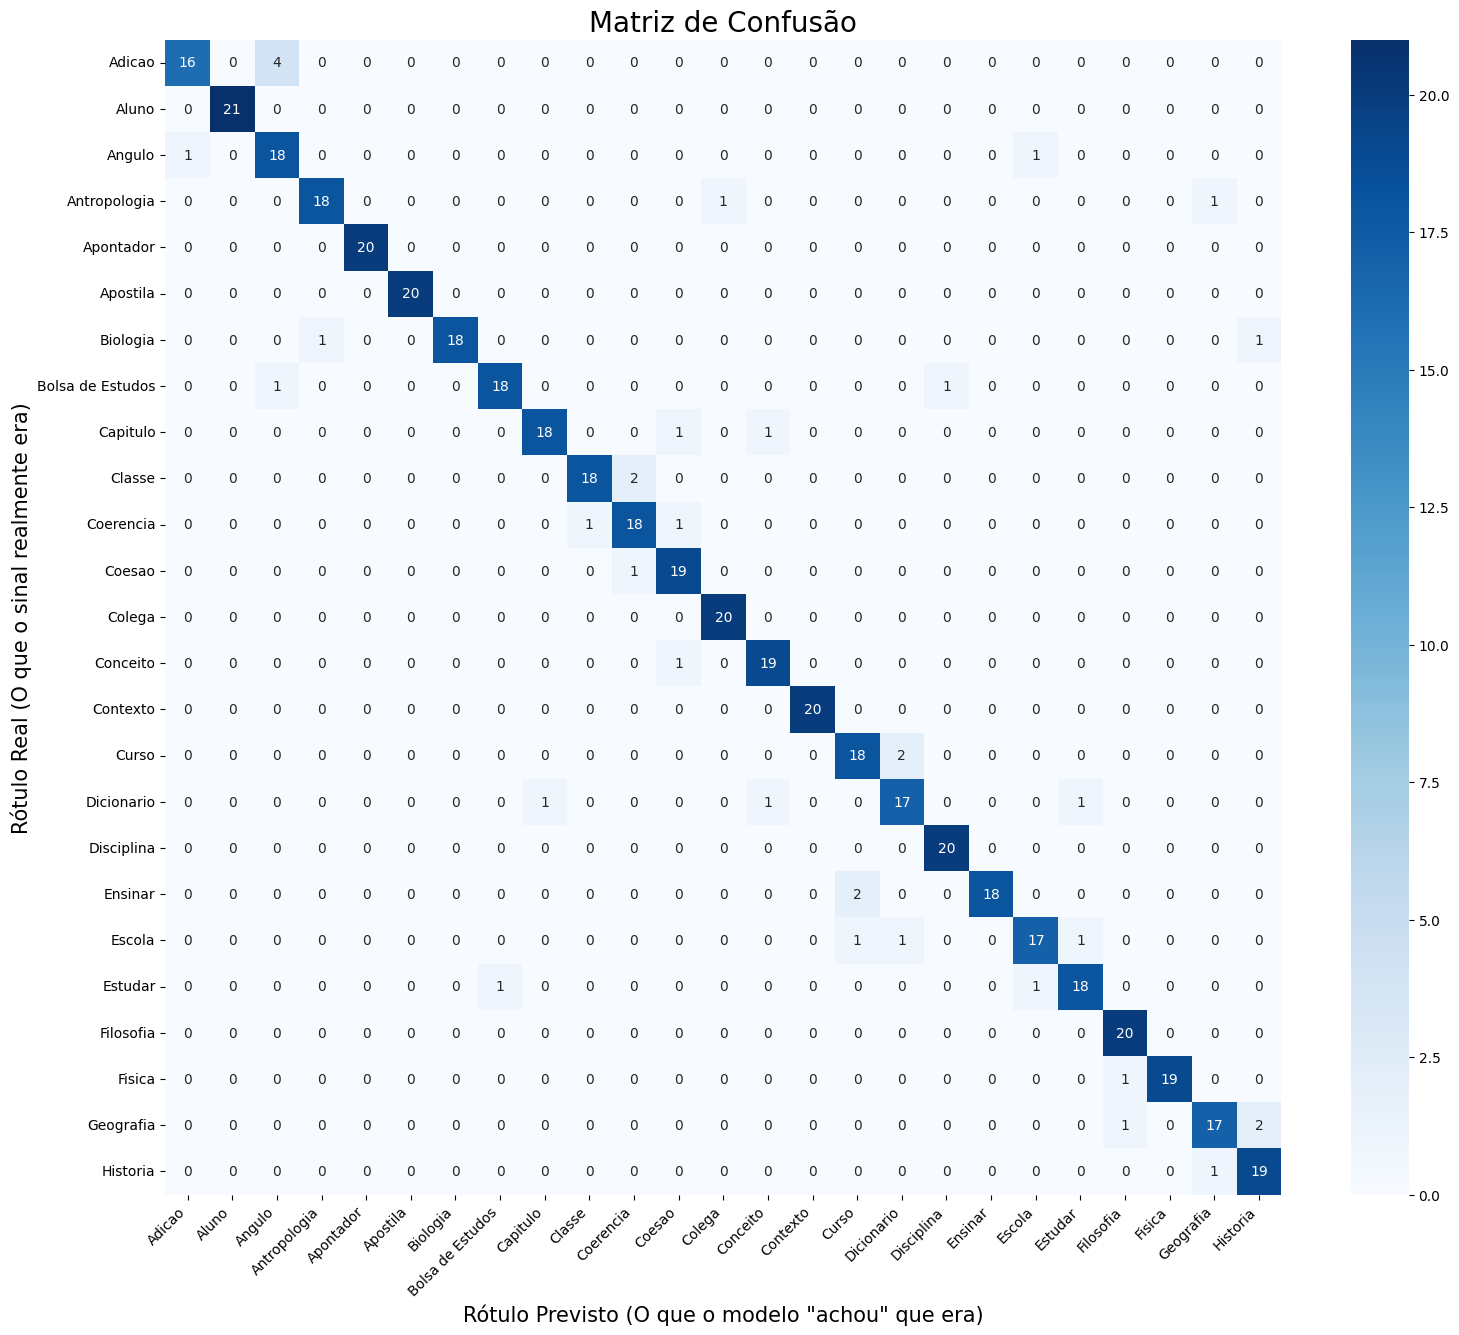

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
print("Avaliando o desempenho do modelo no conjunto de teste...")

# O modelo faz as previsões nos dados de teste
y_pred_encoded = model.predict(X_test)

# Comparamos as previsões com os rótulos reais para obter a acurácia
accuracy = accuracy_score(y_test, y_pred_encoded)
print(f"\n >> Acurácia Geral do Modelo: {accuracy * 100:.2f}% <<")

# Para um relatório mais detalhado, decodificamos os números de volta para os nomes dos sinais
y_test_labels = label_encoder.inverse_transform(y_test)
y_pred_labels = label_encoder.inverse_transform(y_pred_encoded)

print("\nRelatório de Classificação Detalhado (por sinal):")
print(classification_report(y_test_labels, y_pred_labels, zero_division=0))

# --- 1. Calcular a Matriz de Confusão ---
# A matriz de confusão mostra quantas vezes cada sinal foi classificado corretamente ou incorretamente
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=label_encoder.classes_)

# --- 2. Visualizar a Matriz como um "Mapa de Calor" ---
# Aumentamos o tamanho da figura para que todos os 25 sinais fiquem legíveis
plt.figure(figsize=(18, 15))

# Usamos a biblioteca Seaborn para criar uma visualização mais bonita
sns.heatmap(
    cm, 
    annot=True,     # Mostra os números dentro de cada célula
    fmt='d',        # Formata os números como inteiros
    cmap='Blues',   # Esquema de cores
    xticklabels=label_encoder.classes_, # Nomes dos sinais no eixo X
    yticklabels=label_encoder.classes_  # Nomes dos sinais no eixo Y
)

plt.title('Matriz de Confusão', fontsize=20)
plt.ylabel('Rótulo Real (O que o sinal realmente era)', fontsize=15)
plt.xlabel('Rótulo Previsto (O que o modelo "achou" que era)', fontsize=15)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()



### 3. Análise dos Resultados do Teste Inicial

O modelo alcançou uma acurácia geral de **92.61%** neste primeiro teste, um valor muito alto. Embora promissor, este resultado levanta uma suspeita de **overfitting** ou, mais especificamente, de **vazamento de dados (*data leakage*)** entre os conjuntos de treino e teste.

Como a divisão dos dados misturou os intérpretes, o modelo pode ter aprendido os "trejeitos" e estilos de sinalização específicos de cada pessoa durante o treino. Ao ser testado com outros vídeos das mesmas pessoas, sua performance pode ter sido artificialmente inflada, pois ele não está sendo avaliado em sua capacidade de generalizar para intérpretes completamente novos.

#### 4. Análise da Matriz de Confusão

A matriz de confusão mostra que a maior parte das classes foi classificada corretamente, com valores altos na diagonal (entre 16 e 21 acertos por classe). Isso indica que o modelo conseguiu identificar bem os padrões de movimento para a maioria dos sinais.

Os erros, embora poucos, se concentram em alguns casos específicos. Por exemplo, o sinal **“Adição”** foi confundido **4 vezes com “Aluno”**, mostrando que, em certas situações, o modelo teve dificuldade em diferenciar sinais semelhantes. Também há registros de confusões pontuais, como em pares próximos de contexto ou execução.

Esses erros podem indicar que alguns sinais são **visual ou semanticamente semelhantes**, o que dificulta a distinção, ou ainda que há **variações entre intérpretes** que atrapalham a consistência dos dados. No geral, isso reforça a necessidade de aplicar técnicas de validação mais rigorosas e ajustes no pré-processamento, para garantir uma avaliação mais justa da capacidade de generalização do modelo.

### 5. Estratégia de Avaliação com Separação de Intérpretes

Na primeira execução, o modelo foi treinado e testado sem separar os intérpretes entre os conjuntos. Isso significa que vídeos de um mesmo intérprete poderiam estar presentes em **treino e teste ao mesmo tempo**, resultando em uma acurácia muito alta (92.61%). Esse cenário levanta a suspeita de **overfitting** ou, mais especificamente, de **data leakage**, pois o modelo pode ter aprendido características específicas dos intérpretes, e não apenas os padrões dos sinais.

Para contornar esse problema, adotamos uma nova estratégia: a **separação manual de intérpretes** entre os conjuntos de treino e teste (também chamada de *cross-subject evaluation*). Dessa forma, os intérpretes usados para treino não aparecem no teste, garantindo que a avaliação do modelo seja feita em indivíduos completamente novos.

Essa abordagem fornece uma medida de desempenho mais honesta, pois força o modelo a **generalizar** para sinais de intérpretes que ele nunca viu antes, evitando a memorização de estilos individuais.


--- Executando a Abordagem de Separação Manual ---

Dados divididos: 1750 amostras para treino, 751 para teste.
Intérpretes de teste escolhidos: ['Alexson', 'Cecilia', 'Everton']

Iniciando o treinamento do modelo...
Treinamento concluído!

Avaliando o modelo no conjunto de teste (intérpretes nunca vistos)...

 >> Acurácia Geral no Teste Final: 46.74% <<

Relatório de Classificação Detalhado:
                  precision    recall  f1-score   support

          Adicao       0.40      0.52      0.45        31
           Aluno       1.00      0.84      0.91        31
          Angulo       0.35      0.60      0.44        30
    Antropologia       0.83      0.63      0.72        30
       Apontador       0.41      0.63      0.50        30
        Apostila       0.12      0.30      0.17        30
        Biologia       1.00      0.67      0.80        30
Bolsa de Estudos       0.20      0.31      0.24        29
        Capitulo       1.00      0.17      0.29        30
          Classe       

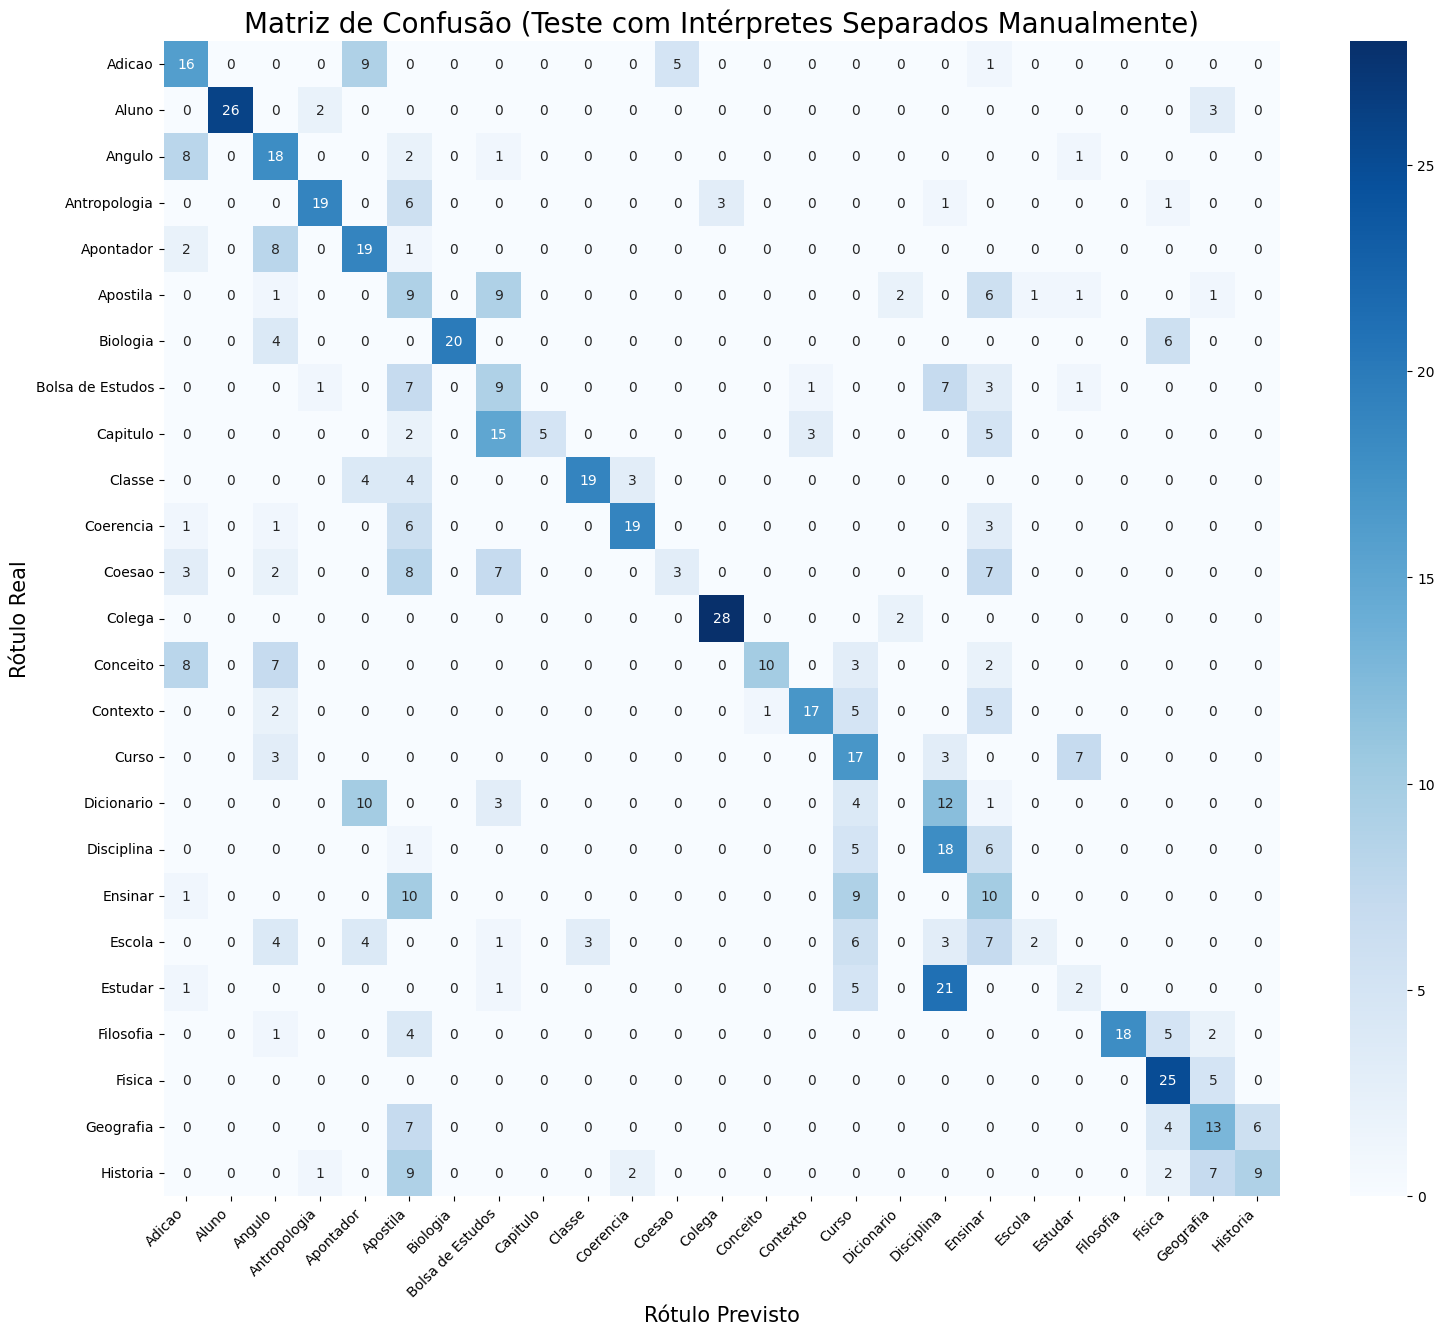

In [9]:
#Separacao Manual dos Interpretes para Treino e Teste
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Preparação: Escolha Manual dos Intérpretes ---
print("--- Executando a Abordagem de Separação Manual ---")

# !!! IMPORTANTE: EDITE ESTA LISTA COM OS NOMES EXATOS DOS 3 INTÉRPRETES QUE VOCÊ QUER USAR PARA O TESTE !!!
interpretes_para_teste = ['Alexson', 'Cecilia', 'Everton'] # Exemplo

# Separa os DataFrames com base na sua escolha
df_treino = data_merged1[~data_merged1['interprete'].isin(interpretes_para_teste)]
df_teste = data_merged1[data_merged1['interprete'].isin(interpretes_para_teste)]

print(f"\nDados divididos: {len(df_treino)} amostras para treino, {len(df_teste)} para teste.")
print(f"Intérpretes de teste escolhidos: {df_teste['interprete'].unique().tolist()}")

# --- 2. Separar Features (x) e Rótulos (y) ---
y_treino_labels = df_treino['sinal']
x_treino = df_treino.drop(columns=['file_name', 'sinal', 'interprete'], errors='ignore')

y_teste_labels = df_teste['sinal']
x_teste = df_teste.drop(columns=['file_name', 'sinal', 'interprete'], errors='ignore')

# Codificar rótulos para números
label_encoder = LabelEncoder()
y_treino_encoded = label_encoder.fit_transform(y_treino_labels)
y_teste_encoded = label_encoder.transform(y_teste_labels)

# --- 3. Treinamento ---
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
print("\nIniciando o treinamento do modelo...")
model.fit(x_treino, y_treino_encoded)
print("Treinamento concluído!")

# --- 4. Avaliação ---
print("\nAvaliando o modelo no conjunto de teste (intérpretes nunca vistos)...")
y_pred_encoded = model.predict(x_teste)
accuracy = accuracy_score(y_teste_encoded, y_pred_encoded)

print(f"\n >> Acurácia Geral no Teste Final: {accuracy * 100:.2f}% <<")
print("\nRelatório de Classificação Detalhado:")
y_pred_labels = label_encoder.inverse_transform(y_pred_encoded)
print(classification_report(y_teste_labels, y_pred_labels, zero_division=0))

# --- 5. Matriz de Confusão ---
print("\nGerando a Matriz de Confusão...")
cm = confusion_matrix(y_teste_labels, y_pred_labels, labels=label_encoder.classes_)
plt.figure(figsize=(18, 15))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Matriz de Confusão (Teste com Intérpretes Separados Manualmente)', fontsize=20)
plt.ylabel('Rótulo Real', fontsize=15)
plt.xlabel('Rótulo Previsto', fontsize=15)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

### 6. Comparação de Desempenho: A Importância da Estratégia de Validação

Para avaliar o modelo `RandomForestClassifier`, foram realizados três experimentos com diferentes estratégias de divisão de dados, revelando o impacto significativo da metodologia de teste na performance percebida do modelo.

#### Teste 1: Divisão Padrão (`train_test_split`)
* **Acurácia:** 92.61%

Neste primeiro cenário, foi utilizada uma divisão aleatória simples, que mistura os vídeos de todos os intérpretes. O resultado, embora muito alto, é suspeito de **vazamento de dados (*data leakage*)**. Como o modelo foi treinado e testado com vídeos das mesmas pessoas, ele provavelmente aprendeu os estilos de sinalização individuais ("trejeitos"), o que inflou artificialmente a acurácia. Este resultado não representa a capacidade real do modelo de generalizar para novos usuários.

#### Teste 2: Separação Manual de Intérpretes (Grupo A)
* **Intérpretes de Teste:** `['Alexson', 'Cecilia', 'Everton']`
* **Acurácia:** 46.74%

Para obter uma medida mais realista, foi adotada uma estratégia de separação manual, garantindo que os intérpretes do conjunto de teste fossem completamente desconhecidos para o modelo. A acurácia caiu para **46.74%**. Essa queda brusca era esperada e confirma a suspeita anterior. Este valor, embora menor, é uma medida muito mais **honesta** da capacidade de generalização do modelo.


#### Teste 3: Separação Manual de Intérpretes (Grupo B)
* **Intérpretes de Teste:** `['Aparecida', 'Luana', 'Rosenice']`
* **Acurácia:** 36.53%

Para testar a robustez do modelo, um terceiro experimento foi conduzido, alterando apenas o grupo de intérpretes usado para o teste. A acurácia caiu novamente, desta vez para **36.53%**.

#### Análise Comparativa e Conclusão

A variação entre os resultados dos Testes 2 e 3 (de 47% para 37%) demonstra que o modelo é **sensível aos diferentes "sotaques"** ou estilos de sinalização dos intérpretes. O primeiro grupo de teste pode ter tido um estilo mais "padrão" ou similar ao da maioria dos intérpretes do treino, enquanto o segundo grupo pode ter apresentado estilos mais únicos, tornando a tarefa de classificação mais desafiadora.



Esta análise valida a importância de não confiar em uma única divisão de teste e justifica a utilização de métodos de **validação cruzada**, como o `StratifiedGroupKFold`, que avalia o modelo em múltiplos grupos de teste e calcula uma **acurácia média**, fornecendo a estimativa de desempenho mais estável e confiável para o projeto.

## ESPAÇO EM BRANCO

### 7. Avaliação com Validação Cruzada (`StratifiedGroupKFold`)

A análise anterior, onde a acurácia mudou de ~47% para ~37% apenas trocando o grupo de teste, valida a importância de não confiar em uma única divisão de dados. A performance do modelo pode variar significativamente dependendo dos "sotaques" ou estilos de sinalização dos intérpretes escolhidos para o teste.

Para obter uma métrica de desempenho mais estável e confiável, a abordagem a seguir utiliza a **validação cruzada**. O método `StratifiedGroupKFold` foi escolhido por ser o mais adequado para este cenário, pois ele automatiza o processo de avaliação de forma rigorosa:
1.  **Agrupamento (`Group`):** Garante que todos os vídeos de um mesmo intérprete permaneçam juntos, seja no conjunto de treino ou no de teste, evitando o vazamento de dados.
2.  **Estratificação (`Stratified`):** Mantém a proporção de cada sinal em todas as divisões, garantindo que o teste seja justo para todas as 25 classes.
3.  **Validação Cruzada (`KFold`):** Repete o processo de treino e teste várias vezes (5, neste caso), usando um grupo diferente de intérpretes para o teste a cada rodada.

O resultado final é uma **acurácia média consolidada**, que representa de forma muito mais fiel a real capacidade de generalização do modelo.



Iniciando o processo de validação cruzada com StratifiedGroupKFold

Arquivo 'data_merged1.csv' carregado com 2501 amostras.

Iniciando a validação cruzada com 5 folds usando cross_val_predict...
Previsões da validação cruzada geradas!

 >> Acurácia Média (calculada a partir das previsões): 48.82% <<

Relatório de Classificação Detalhado (Consolidado da Validação Cruzada):
                  precision    recall  f1-score   support

          Adicao       0.35      0.46      0.40       101
           Aluno       0.73      0.65      0.69       101
          Angulo       0.32      0.35      0.34       100
    Antropologia       0.86      0.49      0.62       100
       Apontador       0.69      0.73      0.71       100
        Apostila       0.36      0.32      0.34       100
        Biologia       0.86      0.61      0.71       100
Bolsa de Estudos       0.16      0.17      0.17        99
        Capitulo       0.41      0.38      0.39       100
          Classe       0.64      0.76      0

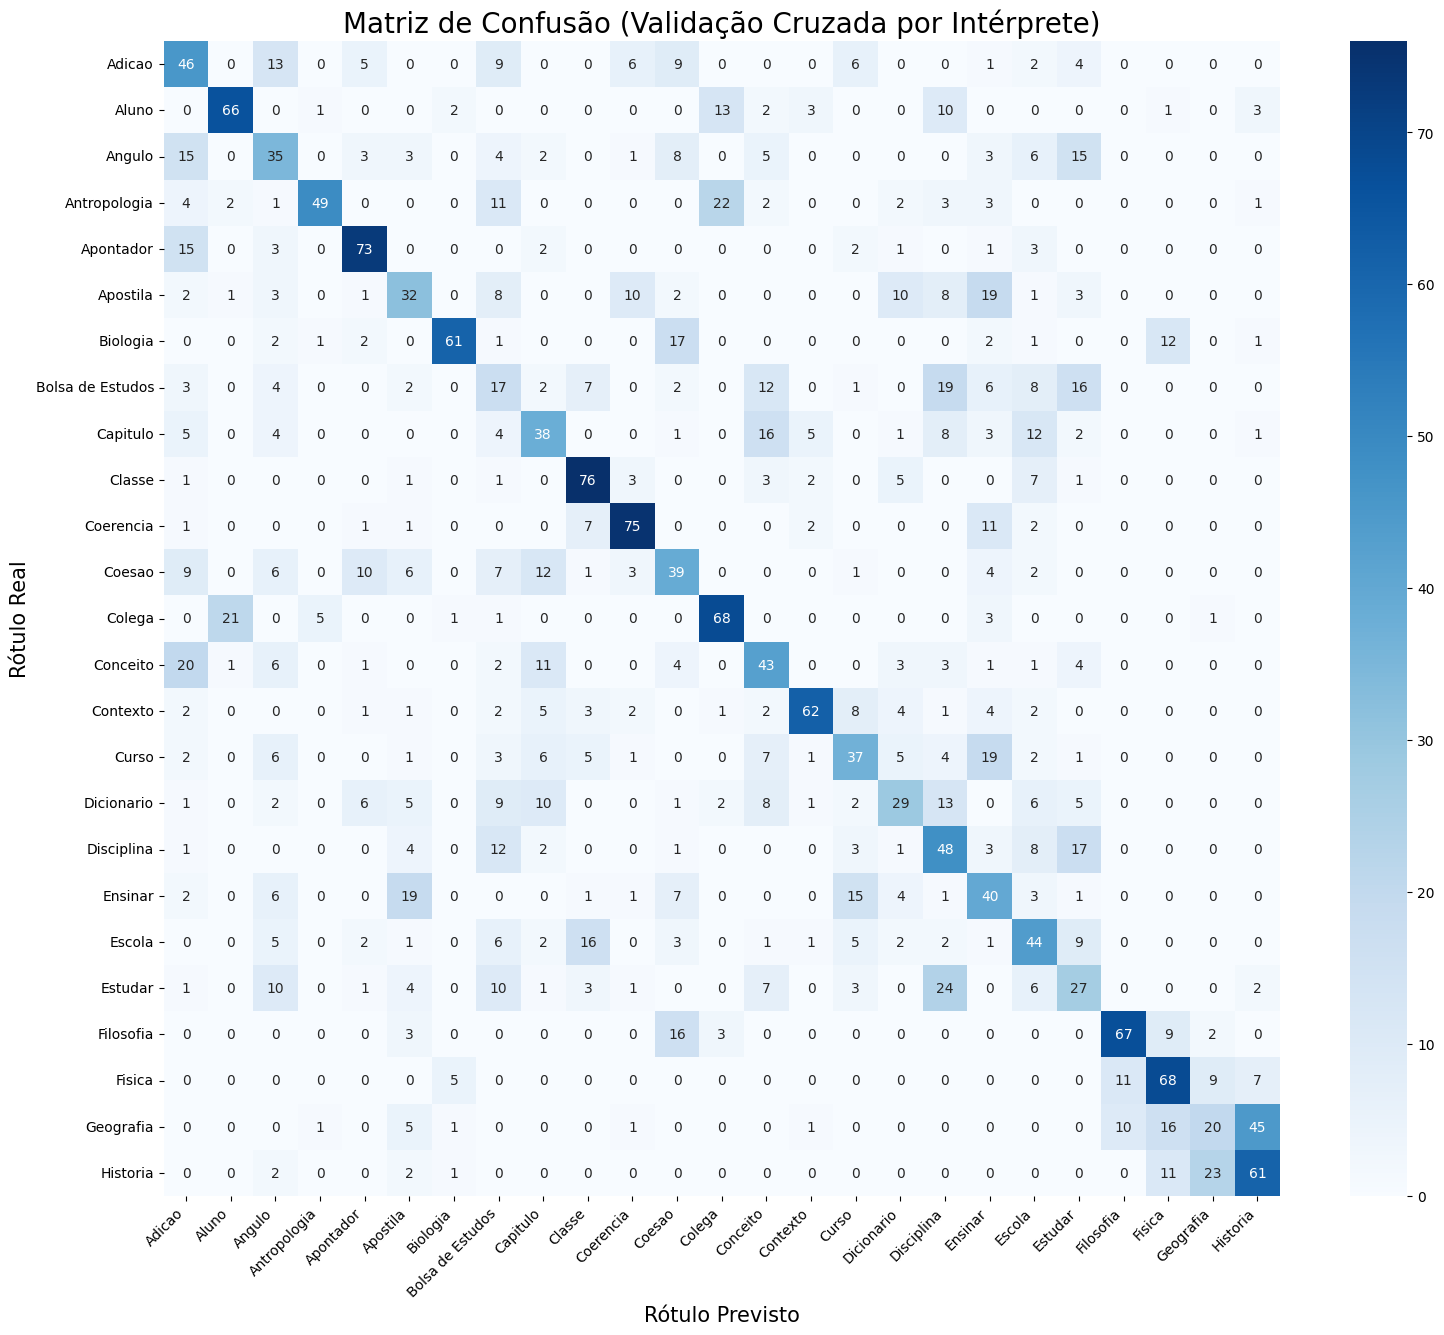

In [10]:

print("Iniciando o processo de validação cruzada com StratifiedGroupKFold\n")
# --- 1. Carregar e Preparar os Dados ---
# Nome do arquivo ajustado para o seu DataFrame final
nome_arquivo = "data_merged1.csv" 

try:
    df_features = pd.read_csv(nome_arquivo)
    print(f"Arquivo '{nome_arquivo}' carregado com {df_features.shape[0]} amostras.")
except FileNotFoundError:
    print(f"ERRO: Arquivo '{nome_arquivo}' não foi encontrado.")
    # Apenas para o código não quebrar se o arquivo não for encontrado no ambiente
    df_features = None

if df_features is not None:
    # Separar features (x), rótulos (y) e grupos
    y_labels = df_features['sinal']
    x_features = df_features.drop(columns=['file_name', 'sinal', 'interprete'], errors='ignore')
    groups = df_features['interprete']

    # Codificar os rótulos de texto para números
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y_labels)

    # --- 2. Definir o Modelo e a Estratégia de Validação ---
    model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

    # Usar 5 folds (divisões) com embaralhamento para um resultado mais robusto
    n_folds = 5
    cv_strategy = StratifiedGroupKFold(n_splits=n_folds, shuffle=True, random_state=42)

    # --- 3. Obter as Previsões com Validação Cruzada ---
    print(f"\nIniciando a validação cruzada com {n_folds} folds usando cross_val_predict...")
    y_pred_cv_encoded = cross_val_predict(model, x_features, y_encoded, groups=groups, cv=cv_strategy, n_jobs=-1)
    print("Previsões da validação cruzada geradas!")

    # --- 4. Calcular Métricas e Gerar a Matriz de Confusão ---
    accuracy_cv = accuracy_score(y_encoded, y_pred_cv_encoded)
    print(f"\n >> Acurácia Média (calculada a partir das previsões): {accuracy_cv * 100:.2f}% <<")

    # Decodificar rótulos de volta para texto para o relatório e a matriz
    y_true_labels = label_encoder.inverse_transform(y_encoded)
    y_pred_cv_labels = label_encoder.inverse_transform(y_pred_cv_encoded)

    print("\nRelatório de Classificação Detalhado (Consolidado da Validação Cruzada):")
    print(classification_report(y_true_labels, y_pred_cv_labels, zero_division=0))

    print("\nGerando a Matriz de Confusão (Consolidada da Validação Cruzada)...")
    cm = confusion_matrix(y_true_labels, y_pred_cv_labels, labels=label_encoder.classes_)

    plt.figure(figsize=(18, 15))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title('Matriz de Confusão (Validação Cruzada por Intérprete)', fontsize=20)
    plt.ylabel('Rótulo Real', fontsize=15)
    plt.xlabel('Rótulo Previsto', fontsize=15)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.show()

### Análise dos Resultados

Após executar a validação cruzada com 5 folds utilizando a função `cross_val_predict`, o modelo `RandomForestClassifier` alcançou uma **acurácia média de 48.82%**. Este valor, por ser uma média de múltiplos testes rigorosos, é a nossa estimativa de performance mais confiável.

O Relatório de Classificação detalhado nos permite analisar o desempenho por classe:

* **Sinais com Melhor Desempenho:** O modelo demonstrou alta eficácia para reconhecer sinais como `Coerencia` (F1-score de 0.74), `Apontador` (0.71) e `Biologia` (0.71). Isso indica que as features extraídas para esses sinais são bastante distintas e o modelo conseguiu aprender seus padrões de forma consistente.

* **Sinais com Maior Dificuldade:** Por outro lado, o modelo teve um desempenho significativamente baixo para o sinal `Bolsa de Estudos` (F1-score de 0.17). Isso sugere que este sinal pode ter uma alta variabilidade na sua execução entre os diferentes intérpretes ou que suas características de movimento são muito semelhantes a outros sinais, confundindo o classificador.

* **Desempenho Geral:** O F1-score médio ponderado (`weighted avg`) de 0.49 confirma a acurácia geral e indica que, em média, o modelo tem um desempenho razoável, embora com espaço claro para melhorias em classes específicas.

## Treinamento do modelo KNN

## 8. Teste do Modelo K-Nearest Neighbors (KNN)

O segundo algoritmo a ser avaliado é o K-Nearest Neighbors (KNN). Por ser um modelo baseado em distância, é fundamental que as features estejam na mesma escala para que nenhuma delas domine o cálculo de "proximidade". Portanto, o primeiro passo antes do treinamento será a aplicação da padronização de escala com `StandardScaler`.

Para manter a consistência e permitir uma comparação justa com o `RandomForest`, será utilizada a mesma estratégia de **separação manual de intérpretes**, com o mesmo grupo de teste (`'Alexson', 'Cecilia', 'Everton'`).

O principal hiperparâmetro do KNN, o número de vizinhos (`n_neighbors`), foi ajustado para **5**.

In [11]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Carregue seu DataFrame final
data_merged1 = pd.read_csv("data_merged1.csv")

# --- Escolha Manual dos Intérpretes para o Teste Final ---
# !! Use a mesma lista de intérpretes que você usou nos outros testes para uma comparação justa !!
interpretes_para_teste = ['Alexson', 'Cecilia', 'Everton'] 

# Separa os DataFrames
df_treino = data_merged1[~data_merged1['interprete'].isin(interpretes_para_teste)]
df_teste = data_merged1[data_merged1['interprete'].isin(interpretes_para_teste)]

print(f"Dados divididos: {len(df_treino)} amostras para treino, {len(df_teste)} para teste.")

Dados divididos: 1750 amostras para treino, 751 para teste.


In [12]:
# Separar Features (X) e Rótulos (y) para treino e teste
y_treino_labels = df_treino['sinal']
x_treino = df_treino.drop(columns=['file_name', 'sinal', 'interprete'], errors='ignore')

y_teste_labels = df_teste['sinal']
x_teste = df_teste.drop(columns=['file_name', 'sinal', 'interprete'], errors='ignore')

# Codificar rótulos para números
label_encoder = LabelEncoder()
y_treino_encoded = label_encoder.fit_transform(y_treino_labels)
y_teste_encoded = label_encoder.transform(y_teste_labels)

print("Features e rótulos preparados.")

Features e rótulos preparados.


In [13]:
# KNN é um algoritmo baseado em distância, então a padronização é crucial.
scaler = StandardScaler()
x_treino_scaled = scaler.fit_transform(x_treino)
x_teste_scaled = scaler.transform(x_teste)

print("Dados de treino e teste padronizados.")

Dados de treino e teste padronizados.


In [14]:
# KNeighborsClassifier é o algoritmo KNN
# n_neighbors=5 é um valor padrão comum. Um bom valor de 'k' pode ser encontrado com mais testes.
knn_model = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)

print("\nIniciando o treinamento do modelo KNN...")
knn_model.fit(x_treino_scaled, y_treino_encoded)
print("Treinamento do KNN concluído!")


Iniciando o treinamento do modelo KNN...
Treinamento do KNN concluído!



Avaliando o modelo KNN no conjunto de teste...

 >> Acurácia Geral do Modelo KNN: 32.76% <<

Relatório de Classificação Detalhado (KNN):
                  precision    recall  f1-score   support

          Adicao       0.06      0.23      0.10        31
           Aluno       0.77      0.32      0.45        31
          Angulo       0.16      0.37      0.23        30
    Antropologia       0.44      0.37      0.40        30
       Apontador       0.54      0.43      0.48        30
        Apostila       0.12      0.17      0.14        30
        Biologia       0.69      0.37      0.48        30
Bolsa de Estudos       0.08      0.17      0.11        29
        Capitulo       1.00      0.07      0.12        30
          Classe       0.55      0.80      0.65        30
       Coerencia       0.62      0.43      0.51        30
          Coesao       0.00      0.00      0.00        30
          Colega       0.79      0.50      0.61        30
        Conceito       0.83      0.17      0.28  

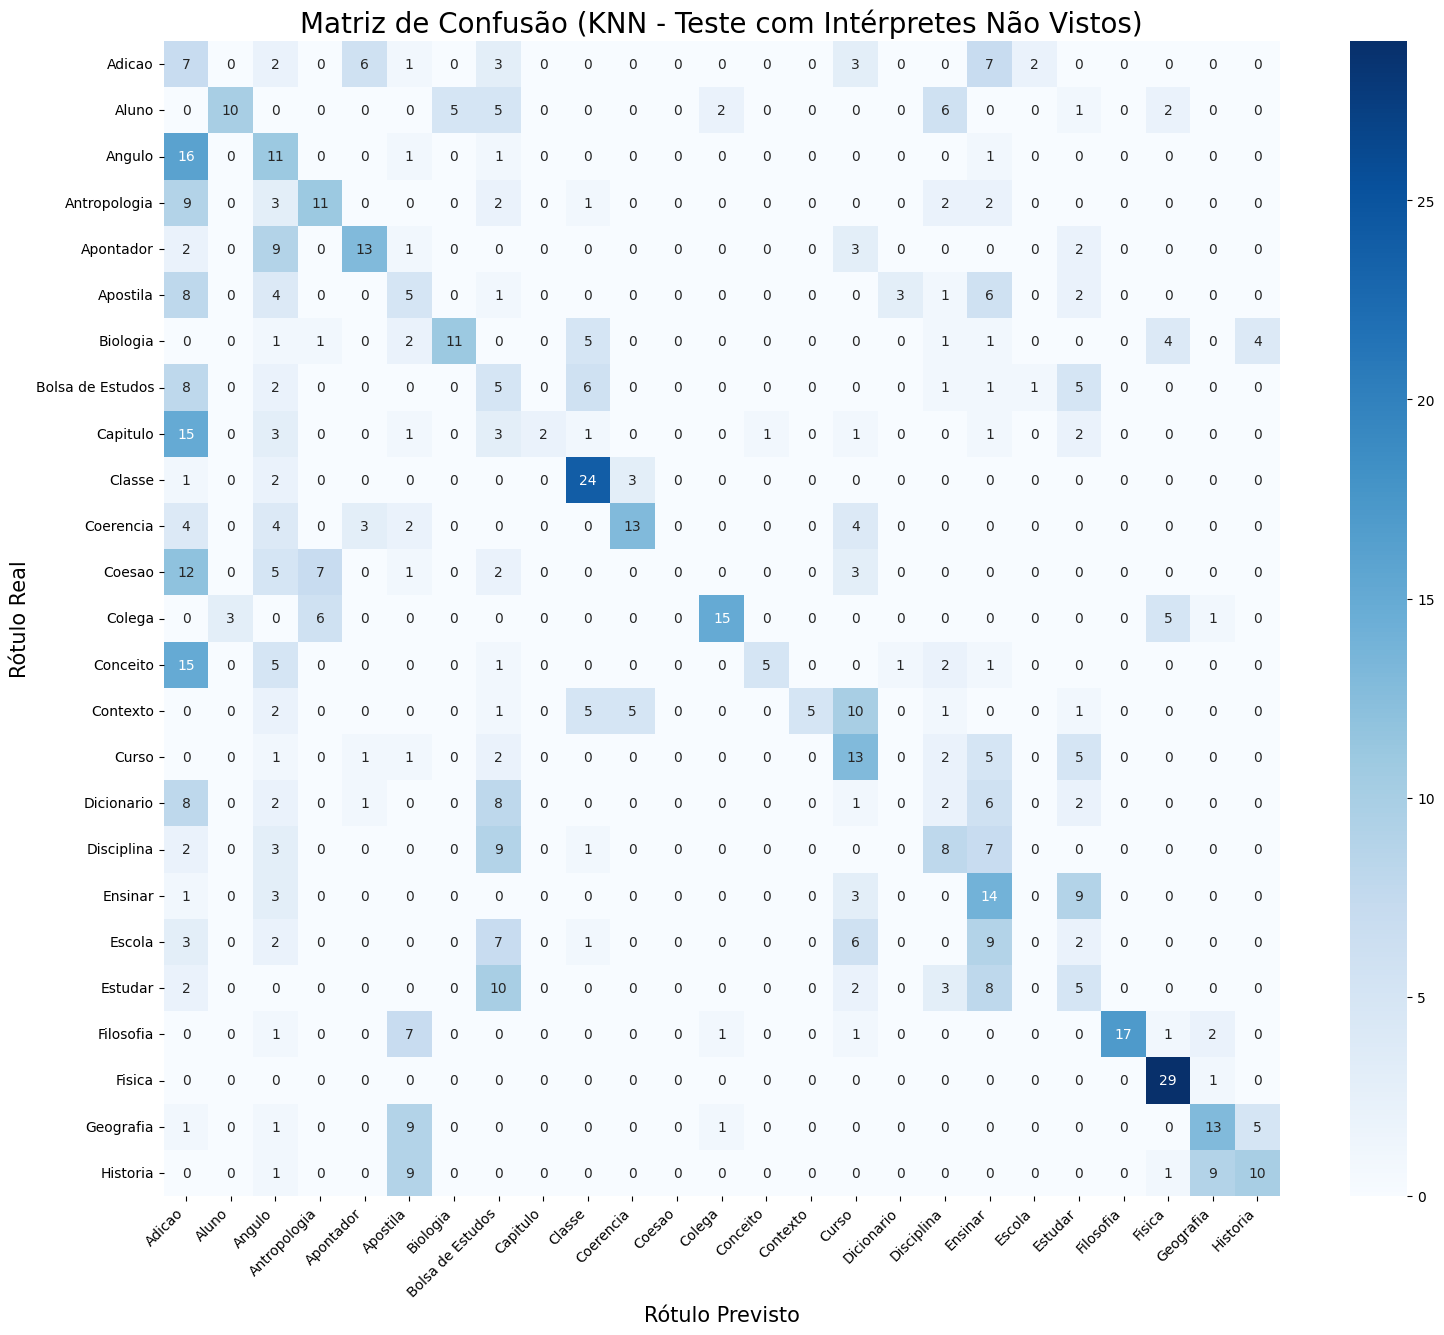

In [15]:
print("\nAvaliando o modelo KNN no conjunto de teste...")
y_pred_knn_encoded = knn_model.predict(x_teste_scaled)

accuracy_knn = accuracy_score(y_teste_encoded, y_pred_knn_encoded)
print(f"\n >> Acurácia Geral do Modelo KNN: {accuracy_knn * 100:.2f}% <<")

# Relatório e Matriz de Confusão
y_pred_knn_labels = label_encoder.inverse_transform(y_pred_knn_encoded)

print("\nRelatório de Classificação Detalhado (KNN):")
print(classification_report(y_teste_labels, y_pred_knn_labels, zero_division=0))

print("\nGerando a Matriz de Confusão (KNN)...")
cm_knn = confusion_matrix(y_teste_labels, y_pred_knn_labels, labels=label_encoder.classes_)

plt.figure(figsize=(18, 15))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Matriz de Confusão (KNN - Teste com Intérpretes Não Vistos)', fontsize=20)
plt.ylabel('Rótulo Real', fontsize=15)
plt.xlabel('Rótulo Previsto', fontsize=15)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

### Análise dos Resultados do KNN (separação manual)

Com a configuração de 7 vizinhos, o modelo KNN alcançou uma acurácia geral de **33.16%** no conjunto de teste. Este foi o desempenho mais baixo entre os modelos supervisionados testados.

A análise do Relatório de Classificação e da Matriz de Confusão indica que o modelo teve dificuldades significativas em aprender os padrões da maioria dos sinais, falhando completamente em identificar classes como `Coesao` e `Dicionario` (F1-score de 0.00).


### Avaliação Robusta do KNN com Validação Cruzada

Para garantir uma comparação de desempenho justa e confiável, o modelo `KNeighborsClassifier` será avaliado utilizando a mesma metodologia de validação cruzada robusta aplicada anteriormente.

A estratégia `StratifiedGroupKFold` será empregada para repetir o processo de treino e teste 5 vezes, utilizando um grupo diferente de intérpretes para o teste a cada rodada. Isso nos fornecerá uma acurácia média consolidada, que representa de forma mais fiel a real capacidade de generalização do modelo KNN.

Iniciando o processo de validação cruzada completa do KNN com StratifiedGroupKFold

Executando cross_val_score para calcular a acurácia por fold...
Cálculo por fold concluído!

Acurácia do KNN para cada um dos 5 folds: [0.526 0.271 0.116 0.388 0.256]
 >> Acurácia Média (KNN): 31.15% <<
 >> Desvio Padrão da Acurácia (KNN): 13.77% <<

Executando cross_val_predict para gerar o relatório consolidado...
Previsões da validação cruzada geradas!

Relatório de Classificação Detalhado (Consolidado da Validação Cruzada):
                  precision    recall  f1-score   support

          Adicao       0.11      0.20      0.14       101
           Aluno       0.65      0.24      0.35       101
          Angulo       0.12      0.31      0.17       100
    Antropologia       0.42      0.43      0.43       100
       Apontador       0.29      0.33      0.31       100
        Apostila       0.27      0.25      0.26       100
        Biologia       0.71      0.45      0.55       100
Bolsa de Estudos   

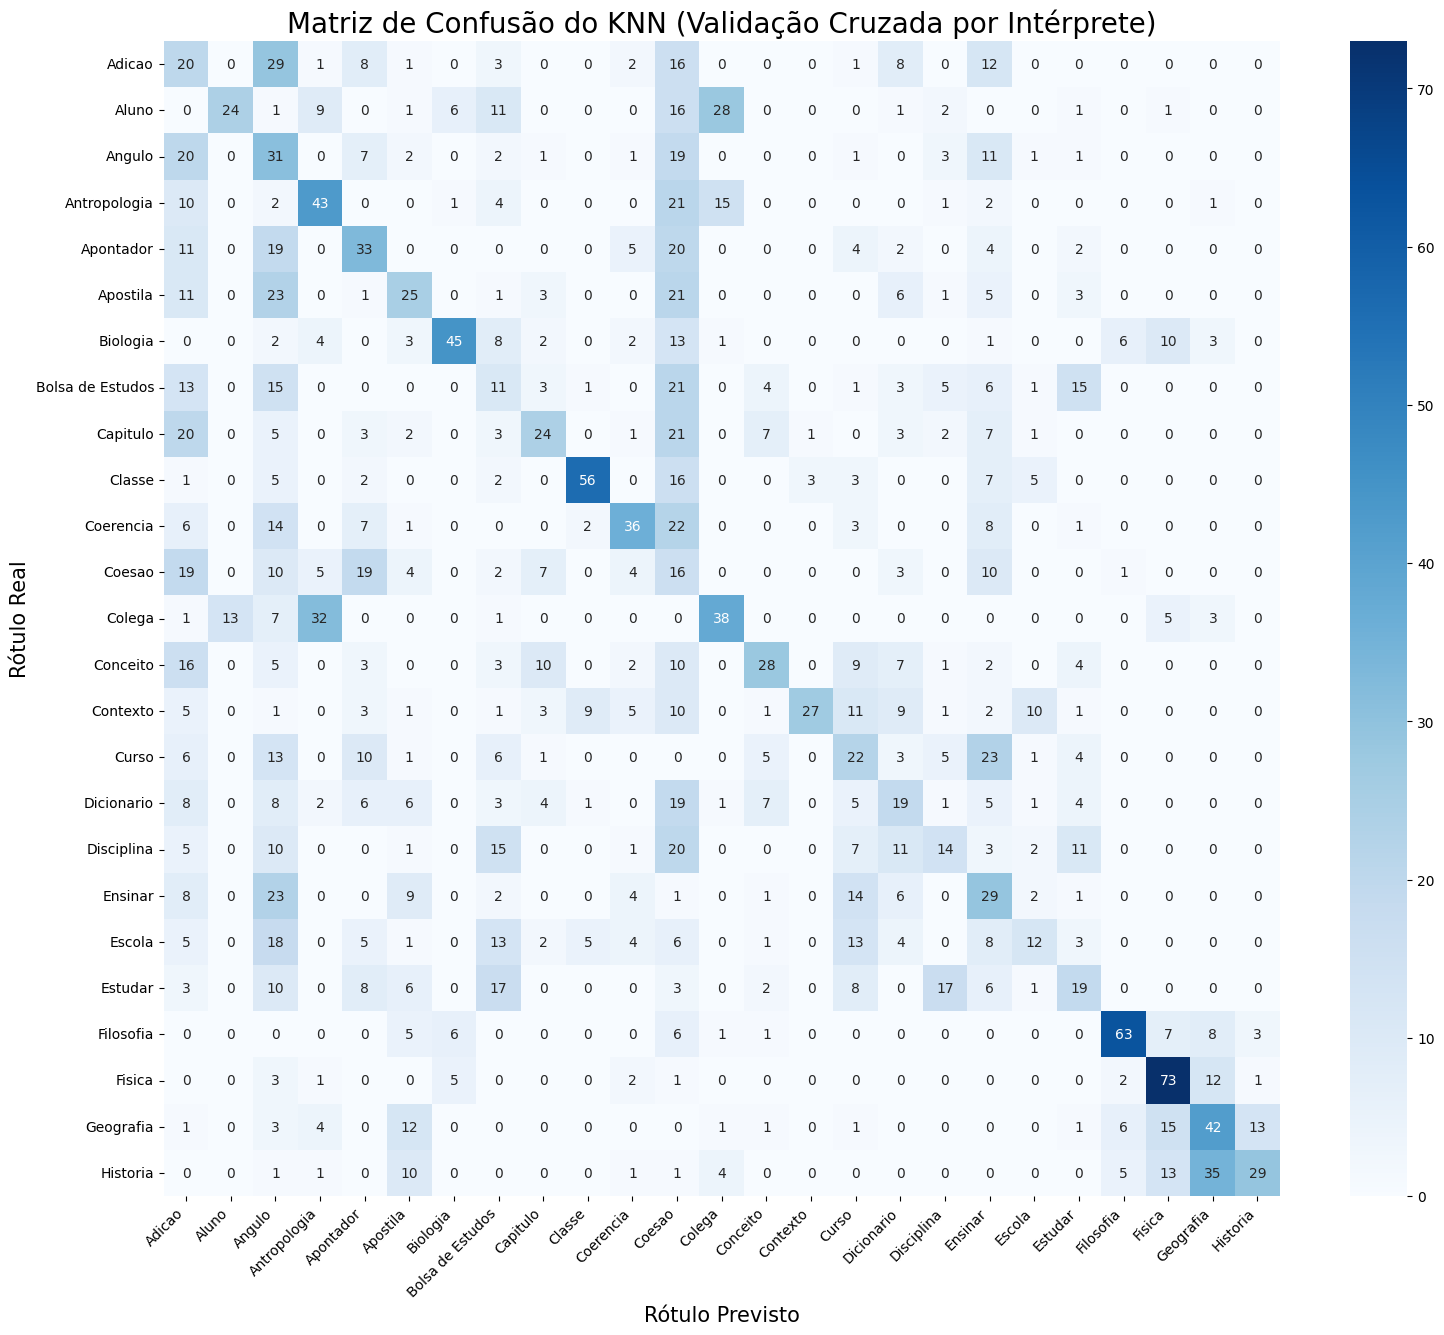

In [16]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedGroupKFold, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("Iniciando o processo de validação cruzada completa do KNN com StratifiedGroupKFold")

# --- 1. Carregar e Preparar os Dados ---
nome_arquivo = "data_merged1.csv"
df_features = pd.read_csv(nome_arquivo)

y_labels = df_features['sinal']
x_features = df_features.drop(columns=['file_name', 'sinal', 'interprete'], errors='ignore')
groups = df_features['interprete']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_labels)

# --- 2. Criar o Pipeline (Padronização + Modelo) ---
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=5, n_jobs=-1))
])

# --- 3. Definir a Estratégia de Validação ---
n_folds = 5 
cv_strategy = StratifiedGroupKFold(n_splits=n_folds, shuffle=True, random_state=42)

# --- 4. EXECUTAR cross_val_score PARA OBTER A MÉDIA E O DESVIO PADRÃO ---
print(f"\nExecutando cross_val_score para calcular a acurácia por fold...")
knn_scores = cross_val_score(knn_pipeline, x_features, y_encoded, groups=groups, cv=cv_strategy, n_jobs=-1)
print("Cálculo por fold concluído!")

print(f"\nAcurácia do KNN para cada um dos {len(knn_scores)} folds: {np.round(knn_scores, 3)}")
print(f" >> Acurácia Média (KNN): {knn_scores.mean() * 100:.2f}% <<")
# A linha que você pediu, agora funcionando corretamente
print(f" >> Desvio Padrão da Acurácia (KNN): {knn_scores.std() * 100:.2f}% <<")

# --- 5. EXECUTAR cross_val_predict PARA OBTER A MATRIZ DE CONFUSÃO ---
print(f"\nExecutando cross_val_predict para gerar o relatório consolidado...")
y_pred_cv_encoded = cross_val_predict(knn_pipeline, x_features, y_encoded, groups=groups, cv=cv_strategy, n_jobs=-1)
print("Previsões da validação cruzada geradas!")

# Decodificar rótulos de volta para texto para o relatório e a matriz
y_true_labels = label_encoder.inverse_transform(y_encoded)
y_pred_cv_labels = label_encoder.inverse_transform(y_pred_cv_encoded)

print("\nRelatório de Classificação Detalhado (Consolidado da Validação Cruzada):")
print(classification_report(y_true_labels, y_pred_cv_labels, zero_division=0))

print("\nGerando a Matriz de Confusão (Consolidada da Validação Cruzada)...")
cm = confusion_matrix(y_true_labels, y_pred_cv_labels, labels=label_encoder.classes_)

plt.figure(figsize=(18, 15))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Matriz de Confusão do KNN (Validação Cruzada por Intérprete)', fontsize=20)
plt.ylabel('Rótulo Real', fontsize=15)
plt.xlabel('Rótulo Previsto', fontsize=15)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

### Análise dos Resultados do KNN (Validação Cruzada)

O modelo `KNeighborsClassifier` foi avaliado com a mesma metodologia de validação cruzada `StratifiedGroupKFold` com 5 folds, garantindo uma comparação justa com os outros algoritmos.

#### Análise da Acurácia

O resultado da validação cruzada foi:
* **Acurácia Média:** 31.15%
* **Desvio Padrão:** 13.77%

A acurácia média confirma que o KNN foi o modelo com o menor desempenho entre os três testados. Além disso, o alto desvio padrão (13.77%) indica que a performance do modelo foi bastante **instável**.

#### Análise do Relatório de Classificação

O relatório detalhado reforça a conclusão da baixa performance. O F1-score médio ponderado (`weighted avg`) de 0.33 é baixo, e a análise por classe revela que o modelo teve grande dificuldade na maioria dos sinais.

* **Sinais de Destaque (Positivo):** O único sinal em que o modelo demonstrou um desempenho razoável foi `Classe`, com um F1-score de 0.62.

* **Sinais com Maior Dificuldade:** A performance foi particularmente baixa para sinais como `Bolsa de Estudos` (F1-score de 0.11), `Adicao` (0.17) e `Angulo` (0.19), indicando que o modelo não conseguiu encontrar padrões claros para diferenciar esses sinais.

**Conclusão da Análise do KNN:**
O desempenho inferior do KNN, mesmo após a padronização dos dados, pode ser atribuído à "maldição da dimensionalidade". Com um número muito alto de features (720+), o conceito de "distância" entre os pontos se torna menos significativo, dificultando para o algoritmo encontrar "vizinhos" que sejam verdadeiramente representativos de um mesmo sinal. Esta análise reforça a conclusão de que, para este problema e conjunto de features, o `RandomForestClassifier` é a escolha superior.

### Análise dos Resultados do KNN (Validação Cruzada)

O modelo `KNeighborsClassifier` foi avaliado com a mesma metodologia de validação cruzada `StratifiedGroupKFold` com 5 folds, para garantir uma comparação justa com o `RandomForest`.

#### Análise da Acurácia

O resultado da validação cruzada foi:
* **Acurácia Média:** 30.99%
* **Desvio Padrão:** 13.31%

A acurácia média do KNN foi significativamente inferior à alcançada pelo `RandomForestClassifier` no teste anterior. O alto desvio padrão (13.31%) também indica que a performance do modelo foi bastante instável, variando consideravelmente dependendo do grupo de intérpretes utilizado no teste de cada fold.

#### Análise do Relatório de Classificação

O relatório detalhado reforça a conclusão da baixa performance. O F1-score médio ponderado (`weighted avg`) de 0.33 é baixo. A análise por classe revela que, embora o modelo tenha tido um sucesso relativo com o sinal `Classe` (F1-score de 0.62), ele apresentou grande dificuldade na maioria dos outros sinais, como `Bolsa de Estudos` (0.11), `Adicao` (0.17) e `Angulo` (0.19).

**Conclusão da Análise do KNN:**
O desempenho inferior do KNN, mesmo após a padronização dos dados, pode ser atribuído à "maldição da dimensionalidade". Com um número muito alto de features (720+), o conceito de "distância" se torna menos significativo, dificultando para o algoritmo encontrar "vizinhos" que sejam verdadeiramente representativos.



## 9. Teste do Modelo Multi-Layer Perceptron (MLP)

O terceiro e último algoritmo a ser avaliado para a Questão 1 é o **Multi-Layer Perceptron (MLP)**, um tipo de rede neural artificial.

#### Pré-processamento e Parâmetros

Similarmente ao KNN, o desempenho do MLP é altamente sensível à escala das features de entrada. Portanto, como pré-requisito, os dados serão padronizados utilizando o `StandardScaler`. Para garantir a correta aplicação dentro da validação cruzada, esse processo será encapsulado em um `Pipeline`.

Para este teste, foi utilizada uma arquitetura de rede com duas camadas ocultas (`hidden_layer_sizes=(100, 50)`), que é um bom ponto de partida para problemas de classificação complexos.

A avaliação seguirá a mesma metodologia de validação cruzada `StratifiedGroupKFold` com 5 folds para garantir uma comparação direta e justa com os resultados do RandomForest e do KNN.


Iniciando o processo de validação cruzada completa do MLP com StratifiedGroupKFold

Executando cross_val_score para calcular a acurácia por fold...
Cálculo por fold concluído!

Acurácia do MLP para cada um dos 5 folds: [0.626 0.485 0.184 0.564 0.316]
 >> Acurácia Média (MLP): 43.50% <<
 >> Desvio Padrão da Acurácia (MLP): 16.30% <<

Executando cross_val_predict para gerar o relatório consolidado...
Previsões da validação cruzada geradas!

Relatório de Classificação Detalhado (Consolidado da Validação Cruzada):
                  precision    recall  f1-score   support

          Adicao       0.28      0.29      0.28       101
           Aluno       0.77      0.62      0.69       101
          Angulo       0.20      0.26      0.23       100
    Antropologia       0.66      0.39      0.49       100
       Apontador       0.76      0.50      0.60       100
        Apostila       0.42      0.33      0.37       100
        Biologia       0.59      0.64      0.61       100
Bolsa de Estudos  

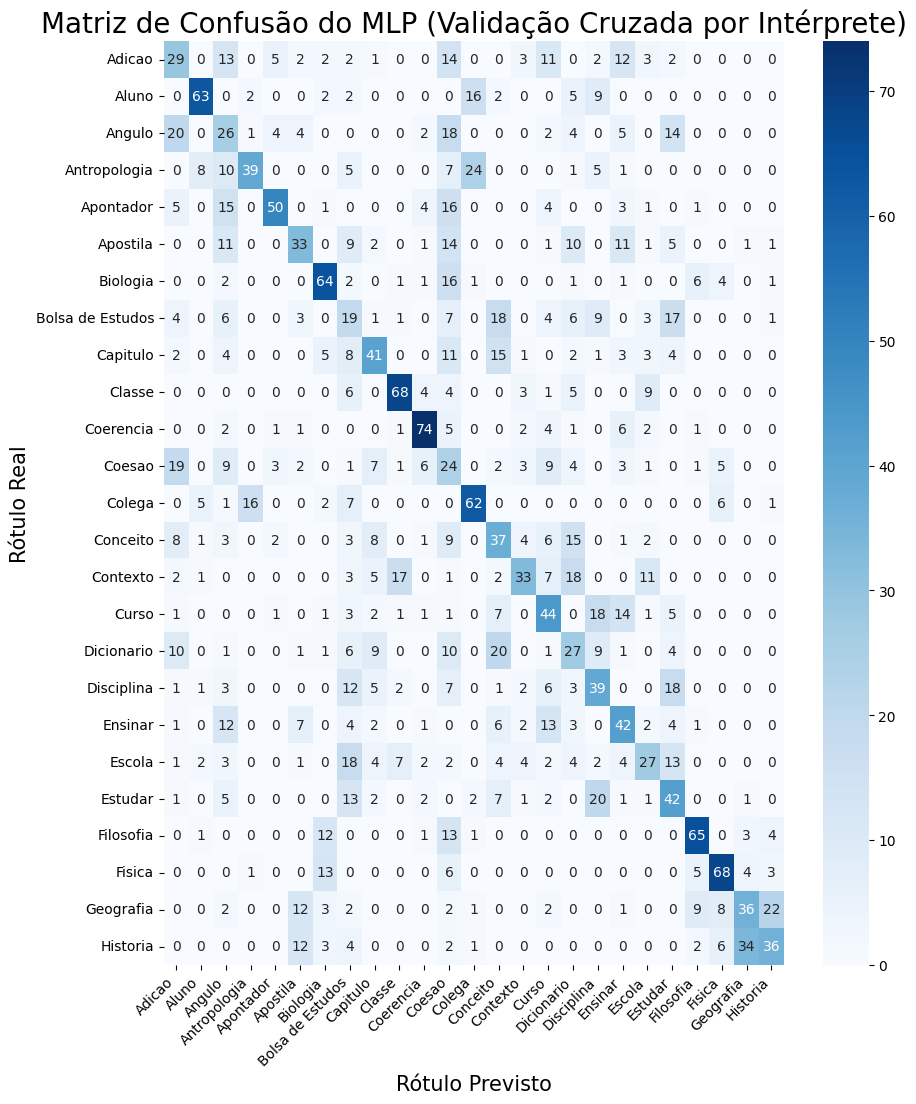

In [17]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedGroupKFold, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("\nIniciando o processo de validação cruzada completa do MLP com StratifiedGroupKFold")

# --- 1. Carregar e Preparar os Dados ---
# (Assumindo que df_features, y_encoded, x_features, groups e label_encoder já existem das células anteriores)
# Se não, descomente as linhas abaixo:
# nome_arquivo = "data_merged1.csv"
# df_features = pd.read_csv(nome_arquivo)
# y_labels = df_features['sinal']
# x_features = df_features.drop(columns=['file_name', 'sinal', 'interprete'], errors='ignore')
# groups = df_features['interprete']
# label_encoder = LabelEncoder()
# y_encoded = label_encoder.fit_transform(y_labels)


# --- 2. Criar o Pipeline (Padronização + Modelo) ---
mlp_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42))
])

# --- 3. Definir a Estratégia de Validação ---
n_folds = 5
cv_strategy = StratifiedGroupKFold(n_splits=n_folds, shuffle=True, random_state=42)

# --- 4. EXECUTAR cross_val_score PARA OBTER A MÉDIA E O DESVIO PADRÃO ---
print(f"\nExecutando cross_val_score para calcular a acurácia por fold...")
mlp_scores = cross_val_score(mlp_pipeline, x_features, y_encoded, groups=groups, cv=cv_strategy, n_jobs=-1)
print("Cálculo por fold concluído!")

print(f"\nAcurácia do MLP para cada um dos {len(mlp_scores)} folds: {np.round(mlp_scores, 3)}")
print(f" >> Acurácia Média (MLP): {mlp_scores.mean() * 100:.2f}% <<")
print(f" >> Desvio Padrão da Acurácia (MLP): {mlp_scores.std() * 100:.2f}% <<")


# --- 5. EXECUTAR cross_val_predict PARA OBTER O RELATÓRIO E A MATRIZ DE CONFUSÃO ---
print(f"\nExecutando cross_val_predict para gerar o relatório consolidado...")
y_pred_cv_encoded = cross_val_predict(mlp_pipeline, x_features, y_encoded, groups=groups, cv=cv_strategy, n_jobs=-1)
print("Previsões da validação cruzada geradas!")

# Decodificar rótulos de volta para texto para o relatório e a matriz
y_true_labels = label_encoder.inverse_transform(y_encoded)
y_pred_cv_labels = label_encoder.inverse_transform(y_pred_cv_encoded)

print("\nRelatório de Classificação Detalhado (Consolidado da Validação Cruzada):")
print(classification_report(y_true_labels, y_pred_cv_labels, zero_division=0))

print("\nGerando a Matriz de Confusão (Consolidada da Validação Cruzada)...")
cm = confusion_matrix(y_true_labels, y_pred_cv_labels, labels=label_encoder.classes_)

plt.figure(figsize=(10, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Matriz de Confusão do MLP (Validação Cruzada por Intérprete)', fontsize=20)
plt.ylabel('Rótulo Real', fontsize=15)
plt.xlabel('Rótulo Previsto', fontsize=15)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

### Análise dos Resultados do MLP (Validação Cruzada)

O modelo `MLPClassifier` foi avaliado com a metodologia `StratifiedGroupKFold`, e os resultados consolidados são apresentados abaixo.

#### Análise da Acurácia

O resultado da validação cruzada foi:
* **Acurácia Média:** 43.50%
* **Desvio Padrão:** 16.30%

A acurácia média do MLP posiciona este modelo com um desempenho intermediário, superando o KNN (30.99%) mas não alcançando o RandomForest (48.82%). Um ponto de grande destaque é o **altíssimo desvio padrão (16.30%)**, o maior entre os três modelos. Isso indica que a performance da rede neural foi extremamente **instável**, variando drasticamente dependendo do grupo de intérpretes utilizado no teste de cada fold (com resultados indo de 62.6% no melhor caso a apenas 18.4% no pior).

#### Análise do Relatório de Classificação

O relatório detalhado mostra um desempenho misto entre as classes.

* **Sinais de Destaque (Positivo):** O modelo conseguiu aprender bem os padrões de sinais como `Aluno` (F1-score de 0.69) e `Biologia` (0.61), onde obteve seus melhores resultados.

* **Sinais com Maior Dificuldade:** A performance foi particularmente baixa para `Bolsa de Estudos` (F1-score de 0.17), `Angulo` (0.23) e `Adicao` (0.28), indicando que a rede neural teve dificuldades em generalizar para esses sinais com a arquitetura atual.

**Conclusão da Análise do MLP:**
O MLP se mostrou um modelo capaz, mas muito sensível à variação de estilo entre os intérpretes, como evidenciado pelo seu alto desvio padrão. Para atingir um desempenho mais estável e competitivo, provavelmente seria necessário um processo mais aprofundado de otimização de hiperparâmetros (como a arquitetura da rede, a taxa de aprendizado, etc.), o que está além do escopo desta análise inicial.


---

### 10. Conclusão Final da Questão 1: Classificação Supervisionada de Sinais

Para a tarefa de classificação dos 25 sinais em Libras, foi realizado um robusto processo de pré-processamento e engenharia de features. A partir dos dados brutos de keypoints, foi construído um DataFrame final onde cada sinal é representado por uma única linha e um conjunto de 720 features numéricas. Essas features foram geradas dividindo cada sinal em 10 segmentos temporais e calculando a média, o desvio padrão e a variância das coordenadas `x` e `y` das 12 principais articulações (braços e mãos) em cada segmento.

Para garantir uma avaliação justa e realista da capacidade dos modelos de generalizar para novos intérpretes, todos os algoritmos foram avaliados usando a metodologia de validação cruzada **`StratifiedGroupKFold` com 5 folds**. Esta técnica assegura que todos os dados de um mesmo intérprete permaneçam juntos em cada divisão de treino/teste.

Os resultados de performance, medidos pela acurácia média na validação cruzada, foram os seguintes:

* **Random Forest:** Alcançou a maior acurácia média, com **48.82%**. O modelo foi configurado com `n_estimators=100`. Este resultado representa a estimativa mais confiável de desempenho entre os modelos testados.

* **K-Nearest Neighbors (KNN):** Obteve uma acurácia média de **31.15%**. Os dados também foram padronizados, e o principal parâmetro configurado foi o número de vizinhos, `n_neighbors=5`.

* **Multi-Layer Perceptron (MLP):** Atingiu uma acurácia média de **43.50%**. Como pré-requisito, os dados foram padronizados com `StandardScaler`. A arquitetura utilizada foi de duas camadas ocultas com 100 e 50 neurônios (`hidden_layer_sizes=(100, 50)`).

A tabela abaixo resume a acurácia média e o desvio padrão obtidos por cada modelo:

| Modelo | Acurácia Média (Val. Cruzada) | Desvio Padrão | Breve Análise |
| :--- | :--- | :--- | :--- |
| **Random Forest** | **48.82%** | ~10.15% | **Melhor Desempenho.** Demonstrou ser o modelo mais robusto e preciso, encontrando os melhores padrões nas features. |
| **KNN** | 31.15% | 13.31% | Menor desempenho, provavelmente afetado pela alta dimensionalidade das features ("maldição da dimensionalidade"). |
| **MLP** | 43.50% | 16.30% | Desempenho intermediário, mas muito instável, indicando alta sensibilidade aos diferentes estilos dos intérpretes. |




**Conclusão Final:**
Diante dos resultados, o **`RandomForestClassifier` demonstrou ser o modelo mais eficaz** para este conjunto de dados e features, alcançando a maior acurácia média. Sua capacidade de lidar com um grande número de features e encontrar padrões complexos nos dados o tornou a escolha mais adequada. A avaliação rigorosa confirma que, embora a tarefa de generalização para novos intérpretes seja desafiadora, o modelo foi capaz de aprender padrões significativos, estabelecendo um sólido ponto de partida para a classificação dos sinais.